<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/single_cell_umap_before_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial: single-cell transcriptomics using UMAP analysis & visualization

(In comparison to : [GPU baseline](https://github.com/dcolinmorgan/grph/blob/main/single_cell_g_umap_demo.ipynb))

## Setup

In [ ]:
!pip install scanpy

import scanpy as sc
import anndata
import os, time
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pstats import Stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)


## Data Download & Description

In [3]:
#download 6 single cell datasets
%%bash
wget -nc -q https://www.dropbox.com/s/h1k7jy0kad6fguu/GSE107910_40.h5ad.zip
wget -nc -q https://www.dropbox.com/s/xza477kxj7vgdlr/GSE67123_6.h5ad.zip

unzip -o GSE107910_40.h5ad.zip
unzip -o GSE67123_6.h5ad.zip

mkdir -p single_cell
mv *.h5ad single_cell

Archive:  GSE107910_40.h5ad.zip
  inflating: GSE107910_40.h5ad       
Archive:  GSE67123_6.h5ad.zip
  inflating: GSE67123_6.h5ad         


In [4]:

list_files = []
for dirname, _, filenames in os.walk('single_cell'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        list_files.append(os.path.join(dirname, filename))

for fn in list_files:
    adata = sc.read(fn) # sc.read_h5ad
    print( adata.uns['info'] )
    print()

['Thymus (Drop-seq)' 'Validation' '15429' '9307.0' 'nan' '9307' '19530'
 '8' '8' 'UMI' 'Mouse' '1' 'Thymus' 'Drop-seq' 'Timepoints' 'in vivo'
 '29884461' '20180619' 'GSE107910' 'Immunity'
 'Only hematopoietic cells, selected based on detectable Ptprc expression, were considered in this dataset. ']

['Embryonic HSCs (Tang et al.)' 'Validation' '143' 'nan' 'nan' '143'
 '24028' '5' '5' 'TPM/FPKM' 'Mouse' '1' 'Embryo' 'Tang et al.'
 'Timepoints' 'in vivo' '27225119' '20160526' 'GSE67123' 'Nature' 'nan']



## scanpy read and compute UMAP for GSE107910_40 dataset

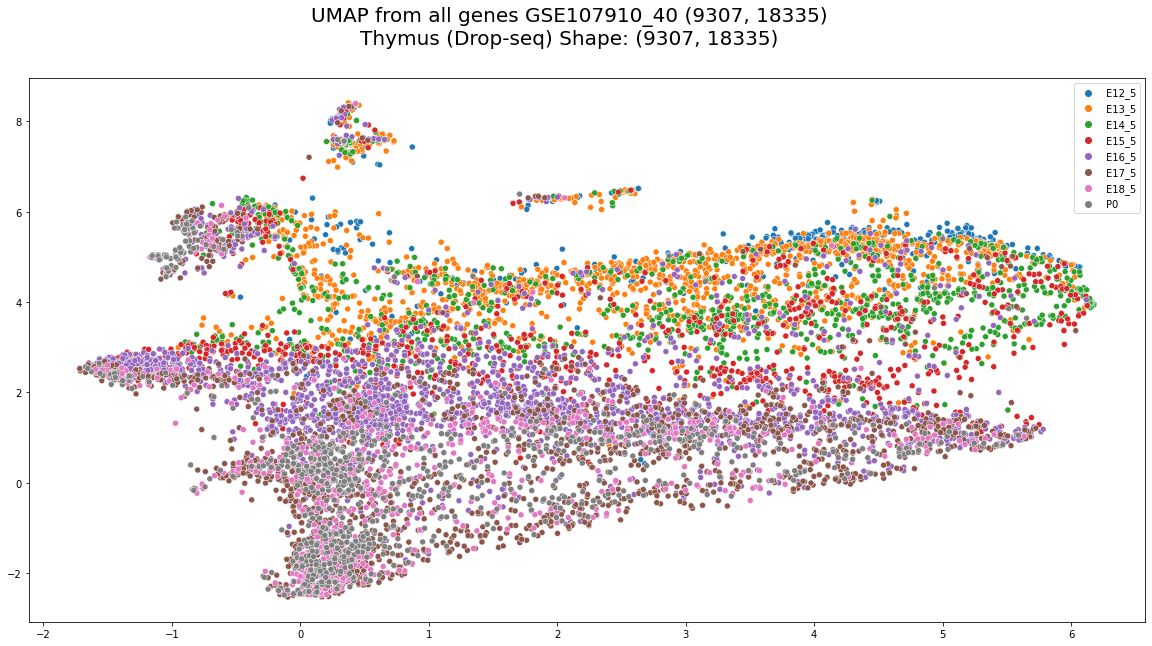

Total  102.4 seconds passed


In [5]:
import time, umap
t0 = time.time()

fn='single_cell/GSE107910_40.h5ad'
adata1 = sc.read(fn) # sc.read_h5ad
str_data_inf = fn.split('/')[1].split('.')[0] + ' ' + str(adata1.X.shape)+'\n' + adata1.uns['info'][0]

reducer = umap.UMAP()
r1 = reducer.fit_transform(adata1.X)

fig = plt.figure(figsize = (20,10)); c = 0
plt.suptitle('UMAP from all genes ' +str_data_inf + ' Shape: ' + str(adata1.X.shape) , fontsize = 20  )
sns.scatterplot(x = r1[:,0], y = r1[:,1]  , hue = adata1.uns['Phenotype'])
plt.show()


print('Total ', np.round(time.time() - t0,1), 'seconds passed')


## this paper was specifically interested in peak mitosis genes, ie ["Tirosh" genes](https://genome.cshlp.org/content/25/12/1860.short), so lets zoom in on those

In [6]:
S_phase_genes_Tirosh = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
G2_M_genes_Tirosh = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
u = 'allgenenames'
list_genes_upper = [t.upper() for t in adata.uns[u] ]
I = np.where( pd.Series(list_genes_upper).isin( S_phase_genes_Tirosh + G2_M_genes_Tirosh ) )[0]


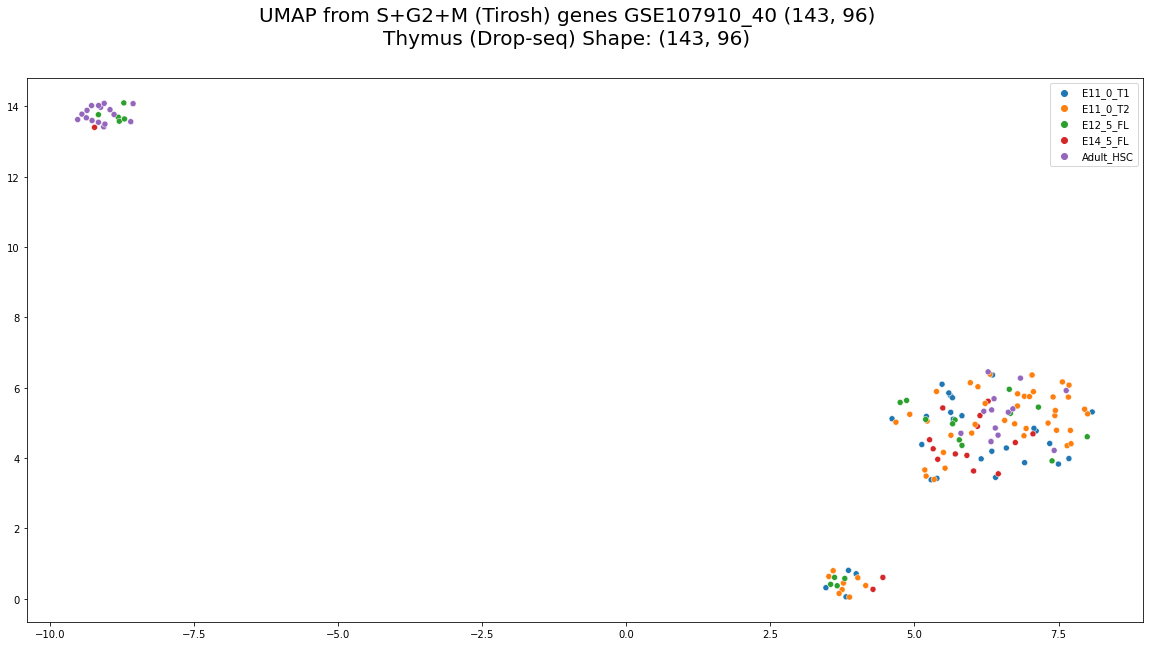

Total  8.5 seconds passed


In [7]:
t0 = time.time()

str_data_inf = fn.split('/')[1].split('.')[0] + ' ' + str(adata.X[:,I].shape)+'\n' + adata1.uns['info'][0]

reducer = umap.UMAP()
r = reducer.fit_transform(adata.X[:,I])

fig = plt.figure(figsize = (20,10)); c = 0
plt.suptitle('UMAP from S+G2+M (Tirosh) genes ' +str_data_inf + ' Shape: ' + str(adata.X[:,I].shape) , fontsize = 20  )
sns.scatterplot(x = r[:,0], y = r[:,1],hue = adata.uns['Phenotype'])

plt.show()

print('Total ', np.round(time.time() - t0,1), 'seconds passed')
